# **GradCAM Visualization with VGG16 and tf-explain**

In this notebook, we demonstrate how to use GradCAM (Gradient-weighted Class Activation Mapping) to visualize the important regions of an image for a deep learning model's predictions. We use a VGG16 model pre-trained on ImageNet to perform this visualization. The process includes:

1. Setup: Installing and importing required libraries.
2. Data Loading & Preprocessing: Loading a sample image (e.g., a cat image from ImageNet) and preparing it for model input.
3. GradCAM Implementation: Defining helper functions to generate a GradCAM heatmap with smoothing and normalization.
4. Overlaying Heatmap: Blending the heatmap with the original image to highlight the regions that influenced the model’s prediction.
5. Visualization: Displaying the original image, the heatmap, and the top three predictions from the model.

 **Installation & Library Imports**

In [15]:
!pip install -q tf-explain

In [16]:
# Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib.colors import LinearSegmentedColormap
import cv2

**Dataset Description :**

For demonstration purposes, we use a single sample image (cat.jpg). This image is assumed to be from the ImageNet dataset and represents a real-world example of an image from one of the 1000 classes on which the VGG16 model was trained. You can replace this image with any other image of your choice.

# Data Loading & Preprocessing Functions

This cell defines a function to load an image, resize it to the model's expected input size, and preprocess it for both visualization and model prediction.

In [17]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess image for both display and model input."""
    # Load image and convert to array
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img).astype(np.uint8)

    # Prepare batch for prediction
    img_batch = np.expand_dims(img_array, axis=0)
    img_batch_preprocessed = preprocess_input(img_batch)

    return img_array, img_array, img_batch_preprocessed


# Helper Functions for Heatmap Processing

Here we define functions to create a custom colormap, smooth the heatmap using Gaussian blur, and normalize/enhance the heatmap for better visualization.

In [18]:
def create_custom_colormap():
    """Create a custom colormap for better visualization."""
    colors = ['#000066', '#0000FF', '#00FFFF', '#FFFF00', '#FF0000']
    return LinearSegmentedColormap.from_list('custom', colors)

def smooth_heatmap(heatmap, kernel_size=11):
    """Apply Gaussian smoothing to the heatmap."""
    return cv2.GaussianBlur(heatmap, (kernel_size, kernel_size), 0)

def normalize_heatmap(heatmap):
    """Normalize and enhance heatmap."""
    percentile_99 = np.percentile(heatmap, 99)
    heatmap = np.clip(heatmap, 0, percentile_99)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)
    gamma = 0.7
    heatmap = np.power(heatmap, gamma)
    return heatmap


# GradCAM Implementation Function

This cell contains a function that applies GradCAM on the image using a specified convolutional layer from the VGG16 model. It also decodes the top three predictions.

In [19]:
def apply_gradcam(model, img_array, img_batch, layer_name='block5_conv3'):
    """Apply GradCAM with improved heatmap processing."""
    # Get model predictions
    predictions = model.predict(img_batch)
    decoded_predictions = decode_predictions(predictions, top=3)[0]

    # Create GradCAM explainer and prepare data for explanation
    explainer = GradCAM()
    data = ([img_array], None)
    predicted_class_index = np.argmax(predictions[0])

    # Generate GradCAM heatmap
    gradcam_output = explainer.explain(
        data,
        model,
        class_index=predicted_class_index,
        layer_name=layer_name
    )

    # Process heatmap: smooth and normalize
    gradcam_output = smooth_heatmap(gradcam_output)
    gradcam_output = normalize_heatmap(gradcam_output)

    return gradcam_output, decoded_predictions


# Overlaying the Heatmap

This cell defines a function to overlay the processed heatmap onto the original image. The function adjusts the blending based on a custom alpha mask.

In [20]:
def overlay_heatmap(original_img, heatmap, alpha=0.5):
    """Create a superimposed visualization with improved blending."""
    # Ensure original_img is numpy array
    original_img = np.array(original_img)

    # Resize heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Convert heatmap to grayscale if necessary
    if heatmap_resized.ndim == 3 and heatmap_resized.shape[-1] == 3:
        heatmap_gray = cv2.cvtColor(np.uint8(255 * heatmap_resized), cv2.COLOR_BGR2GRAY) / 255.0
    else:
        heatmap_gray = heatmap_resized

    # Create a colored heatmap using OpenCV's COLORMAP_JET
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Create alpha mask based on the grayscale heatmap
    mask = heatmap_gray > np.mean(heatmap_gray)
    alpha_mask = np.zeros_like(heatmap_gray)
    alpha_mask[mask] = alpha
    alpha_mask[~mask] = alpha * 0.3

    # Expand alpha_mask to have three channels
    alpha_mask = np.expand_dims(alpha_mask, axis=-1)
    alpha_mask = np.repeat(alpha_mask, 3, axis=-1)

    # Blend the original image and the colored heatmap
    superimposed = (1 - alpha_mask) * original_img + alpha_mask * heatmap_colored

    return np.uint8(np.clip(superimposed, 0, 255))


# Visualization Pipeline Function

This function ties together all the previous functions: loading the image, generating the GradCAM heatmap, overlaying the heatmap, and plotting the results alongside the model's top three predictions.

In [21]:
def visualize_gradcam(image_path, model, layer_name='block5_conv3'):
    """Complete GradCAM visualization pipeline with improved display."""
    # Load and preprocess image
    original_img, img_array, img_batch = load_and_preprocess_image(image_path)

    # Generate GradCAM output and decode predictions
    gradcam_output, predictions = apply_gradcam(model, img_array, img_batch, layer_name)

    # Create superimposed visualization
    superimposed_img = overlay_heatmap(original_img, gradcam_output)

    # Plotting the results
    fig = plt.figure(figsize=(15, 5))
    gs = plt.GridSpec(1, 3, width_ratios=[1, 1, 1])

    # Original image display
    ax1 = plt.subplot(gs[0])
    ax1.imshow(original_img)
    ax1.set_title('Original Image', pad=20)
    ax1.axis('off')

    # GradCAM heatmap display
    ax2 = plt.subplot(gs[1])
    heatmap_display = ax2.imshow(gradcam_output, cmap=create_custom_colormap())
    ax2.set_title('GradCAM Heatmap', pad=20)
    ax2.axis('off')
    plt.colorbar(heatmap_display, ax=ax2, fraction=0.046, pad=0.04)

    # Add top 3 predictions as text overlay
    pred_text = "Top 3 Predictions:\n"
    for i, (_, label, prob) in enumerate(predictions, 1):
        pred_text += f"{i}. {label}: {prob*100:.1f}%\n"
    plt.figtext(0.02, 0.02, pred_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()


# Run the Visualization

Finally, we load the pre-trained VGG16 model and run the visualization on a sample image. Make sure to update the IMAGE_PATH variable to point to your local or cloud-based image file.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_299']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


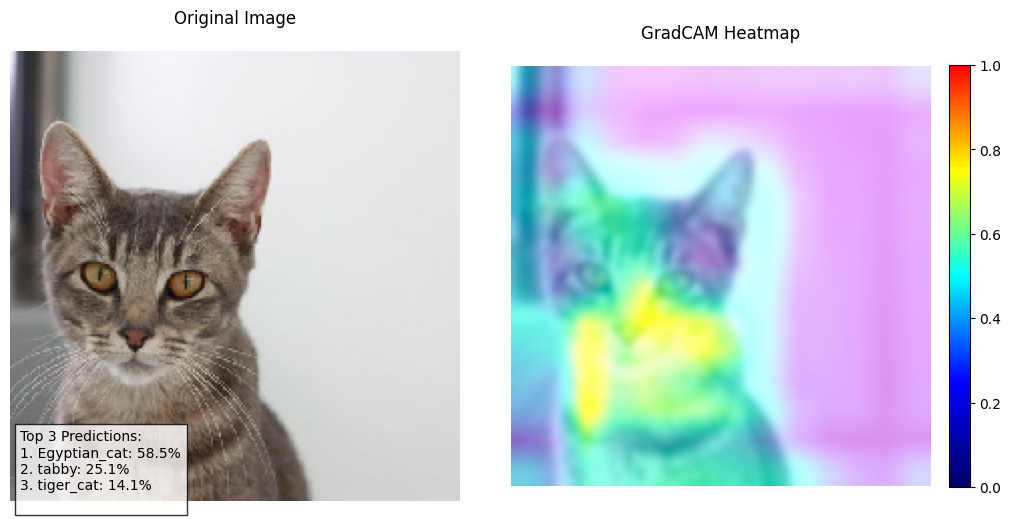

In [22]:
# Define the image path (update this path as needed)
IMAGE_PATH = "/content/cat.jpg"  # Replace with your image path if necessary

# Load the pre-trained VGG16 model with ImageNet weights
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

# Run the GradCAM visualization pipeline
visualize_gradcam(IMAGE_PATH, model)
